In [1]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
from adl.debugger import Debugger
from agent import Agent
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
from adl.kit import animate, interact

pygame 2.2.0 (SDL 2.0.22, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=41) # resets an environment with a seed

In [4]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
# img = env.render("rgb_array", width=640, height=640)
# plt.imshow(img)

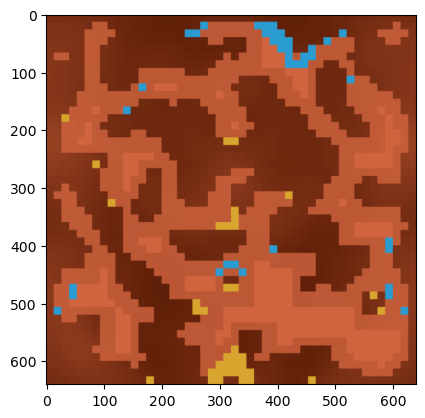

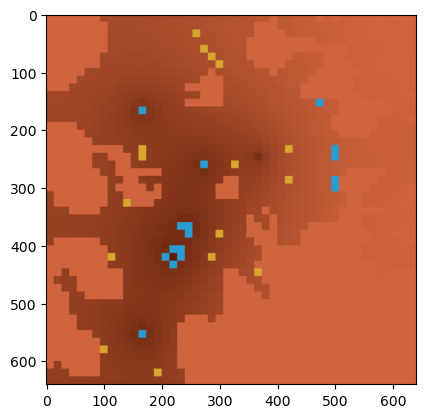

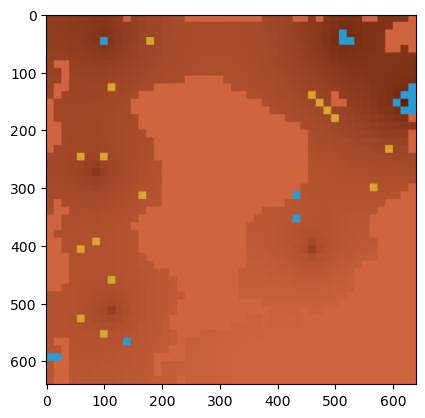

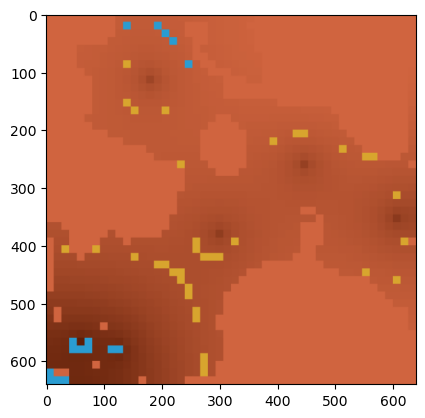

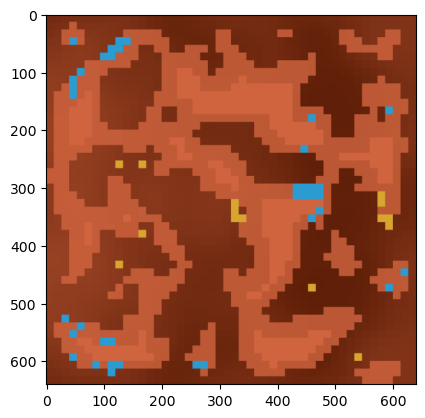

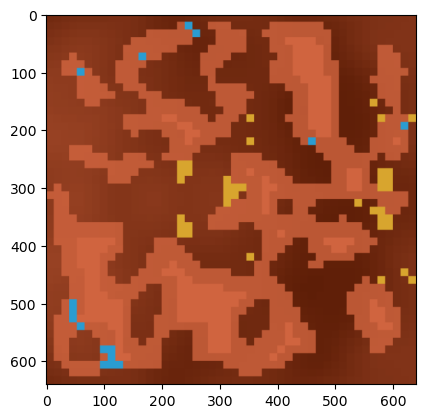

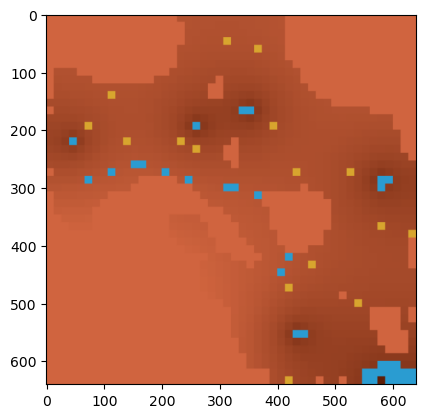

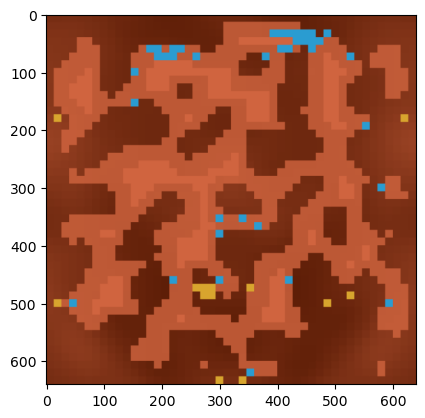

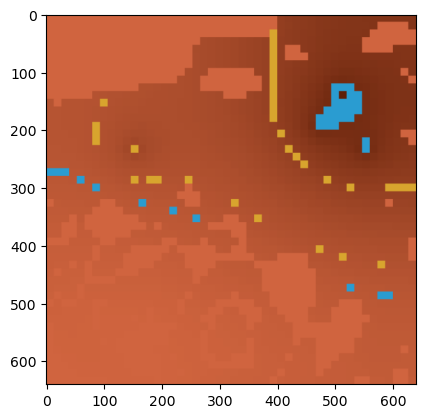

In [5]:
for seed in range(1, 10):
    obs = env.reset(seed=seed) # resets an environment with a seed
    img = env.render("rgb_array", width=640, height=640)
    plt.figure()
    plt.imshow(img)

In [6]:
game_state = obs_to_game_state(0, env.state.env_cfg, obs["player_0"])

In [7]:

from sklearn import metrics
from scipy.spatial.distance import cdist

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

In [9]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

X = np.argwhere(game_state.board.ice == 1)

maxFactories = 8
maxK = min(int(np.sum(game_state.board.ice)), maxFactories)
K = range(1, maxK+1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_



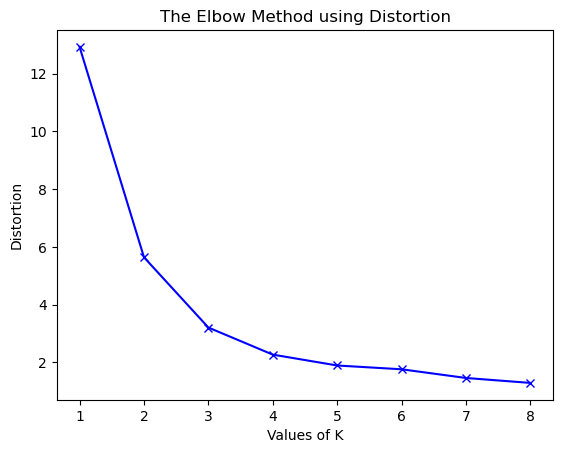

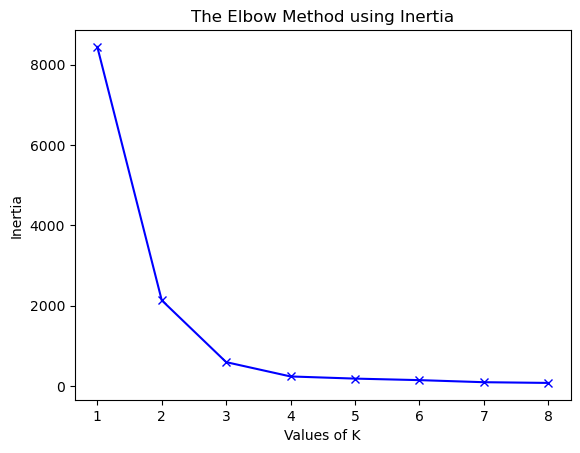

In [10]:
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# for key, val in mapping2.items():
#     print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [11]:
from adl.stats import MapStatsManager, MapStats
from adl.visual_utils import VisualUtils
from adl.debugger import Debugger

debugger = Debugger()
mapStatsManager = MapStatsManager()

 center: (9, 19)
	ice: 8
	closest_ice: [ 6 22]
	closest_ice_distance: 6
	ore: 10
	closest_ore: [11 17]
	closest_ore_distance: 4
	rubble: 4950
 center: (34, 11)
	ice: 25
	closest_ice: [35 13]
	closest_ice_distance: 3
	ore: 16
	closest_ore: [29 11]
	closest_ore_distance: 5
	rubble: 12474
 center: (40, 27)
	ice: 3
	closest_ice: [39 35]
	closest_ice_distance: 9
	ore: 10
	closest_ore: [38 31]
	closest_ore_distance: 6
	rubble: 7439


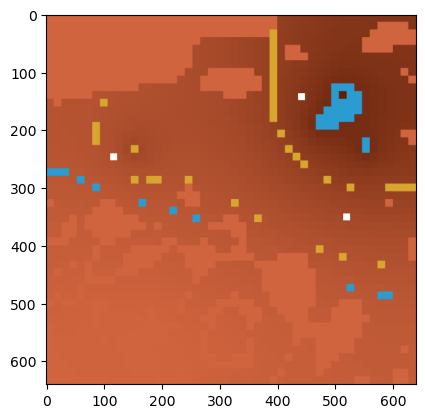

In [12]:
clusters = mapStatsManager.getResourceCluster(game_state)
debugger.printClusters(clusters)
from adl.utils import Utils
img = env.render("rgb_array", width=640, height=640)
VisualUtils.addClustersToImg(img, clusters)
plt.imshow(img)

nIceTiles: 36
nOreTiles: 36
nTotalRubble: 53899
nHighRubble: 373
nLowRubble: 1931
factoriesPerPlayer: 4
resourcePerPlayer: 150
costLichen: 10
costLight: 10
costHeavy: 100
costFactory: 1
chargeFactory: 50
chargeLight: 1
chargeHeavy: 10
Ice Clusters:
 center: (7, 22)
	ice: 8
	closest_ice: [ 6 22]
	closest_ice_distance: 1
	ore: 10
	closest_ore: [11 21]
	closest_ore_distance: 5
	rubble: 3781
 center: (38, 14)
	ice: 28
	closest_ice: [37 14]
	closest_ice_distance: 1
	ore: 26
	closest_ore: [30 15]
	closest_ore_distance: 9
	rubble: 13915
Ore Clusters:
 center: (10, 17)
	ice: 8
	closest_ice: [ 6 22]
	closest_ice_distance: 9
	ore: 9
	closest_ore: [11 17]
	closest_ore_distance: 1
	rubble: 5360
 center: (29, 8)
	ice: 21
	closest_ice: [37  9]
	closest_ice_distance: 9
	ore: 13
	closest_ore: [29  8]
	closest_ore_distance: 0
	rubble: 8521
 center: (37, 23)
	ice: 7
	closest_ice: [37 14]
	closest_ice_distance: 9
	ore: 14
	closest_ore: [36 21]
	closest_ore_distance: 3
	rubble: 9437
Resource Clusters:
 ce

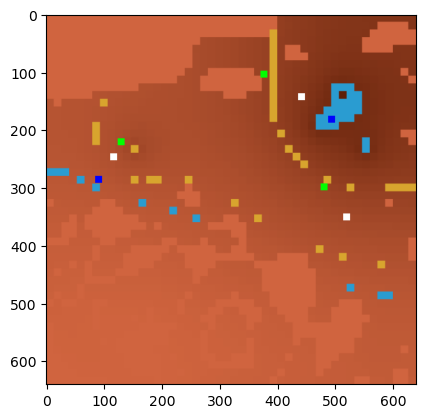

In [13]:
mapStats = mapStatsManager.collectMapStats(game_state)
img = env.render("rgb_array", width=640, height=640)
VisualUtils.addClustersToImg(img, mapStats.iceClusters, np.array([0, 0, 255]))
VisualUtils.addClustersToImg(img, mapStats.oreClusters, np.array([0, 255, 0]))
VisualUtils.addClustersToImg(img, mapStats.resourceClusters, 255)
debugger.printMapStats(mapStats)
plt.imshow(img)

# for statistical analysis we will generate 1M maps and save their analytics
    

In [14]:
from joblib import Parallel, delayed
from adl.stats import MapStatsManager

In [16]:
mapStatsManager = MapStatsManager()

batchSize = 100
nBatches = 10

sessions = Parallel(n_jobs=6) (
    delayed(mapStatsManager.generate)(seed, seed+batchSize) for seed in range(0, batchSize * nBatches, batchSize)
)
 